<div style="text-align: center; font-family: 'Georgia', serif; font-size: 1.2em;">

# Deep Feedforward Networks: Practical Implementation  
**Authors:** Iheb Marouani & Zuzanna Bojarska  
**Seminar:** Deep Learning Concepts, University of Osnabrück (2024/2025)  
**Chapter Focus:** Deep Feedforward Networks

</div>

---

## 1. Setup: Import Libraries and Configure the Environment
We start by importing the required libraries and setting up our environment. PyTorch will be used to define and train our model, and we will use CUDA if it is available.


In [33]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from model.ffn import FeedForwardNetwork  # Import the model from the model directory
from scripts.data_preparation import prepare_data  # Import the data preparation function

# Configure the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## 2. Data Preparation
We prepare the CIFAR-10 dataset by normalizing it and loading it into DataLoader objects for efficient batch processing during training and testing.

In [34]:
trainloader, testloader, classes = prepare_data()


Files already downloaded and verified
Files already downloaded and verified


## 3. Model Architecture
We define a simple feedforward network with three fully connected layers and ReLU activations. The model is designed based on concepts from Chapter 6.

In [35]:
# Initialize the feedforward network and move it to the configured device
model = FeedForwardNetwork().to(device)  # Model from model/ffn.py
print(model)


FeedForwardNetwork(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


## 4. Loss Function and Optimizer:
We use cross-entropy loss for our classification problem and SGD (stochastic gradient descent) as the optimizer to update the model's parameters.

In [36]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Standard loss function for classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Added momentum for better optimization

# Add StepLR scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Adjust the learning rate every 10 epochs


## 5. Training the Model
We train the model over multiple epochs. Each iteration consists of a forward pass, loss calculation, backward pass, and parameter update.


In [37]:
import csv
import os

# Initialize lists to store loss and accuracy values
running_loss_values = []  # For running loss values
average_loss_values = []  # For average loss per epoch
accuracy_values = []  # For storing accuracy per epoch

def save_metrics(epoch, avg_loss, accuracy, output_path="training_metrics.csv"):
    """
    Saves training metrics (loss and accuracy) to a CSV file.

    Args:
        epoch (int): The epoch number.
        avg_loss (float): The average loss for the epoch.
        accuracy (float): The accuracy for the epoch.
        output_path (str): Path to save the CSV file.
    """
    file_exists = os.path.exists(output_path)
    with open(output_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["Epoch", "Average Loss", "Accuracy"])  # Write header
        writer.writerow([epoch, avg_loss, accuracy])

# Define the number of epochs
num_epochs = 15

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_loss = 0.0
    correct = 0
    total = 0

    # Loop through batches in the training loader
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        running_loss += loss.item()
        total_loss += loss.item()

        # Calculate running accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print running loss every 500 mini-batches
        if i % 500 == 499:
            avg_running_loss = running_loss / 500  # Average running loss
            print(f"[{epoch + 1}, {i + 1}] running loss: {avg_running_loss:.3f}")
            running_loss_values.append(avg_running_loss)
            running_loss = 0.0  # Reset running loss

    # Calculate and store average loss for the epoch
    avg_epoch_loss = total_loss / len(trainloader)
    average_loss_values.append(avg_epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] average loss: {avg_epoch_loss:.3f}")

    # Calculate and store accuracy for the epoch
    epoch_accuracy = (correct / total) * 100
    accuracy_values.append(epoch_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}] accuracy: {epoch_accuracy:.2f}%")

    # Save weights for the epoch
    weights_path = f'weights/weights_epoch_{epoch + 1}.pth'
    torch.save(model.state_dict(), weights_path)
    print(f"Weights saved for epoch {epoch + 1} at {weights_path}")

    # Save metrics to CSV
    save_metrics(epoch + 1, avg_epoch_loss, epoch_accuracy)

    # Step the learning rate scheduler
    scheduler.step()

print("Finished Training")


[1, 500] running loss: 1.803
[1, 1000] running loss: 1.617
[1, 1500] running loss: 1.526
Epoch [1/15] average loss: 1.645
Epoch [1/15] accuracy: 41.53%
Weights saved for epoch 1 at weights/weights_epoch_1.pth
[2, 500] running loss: 1.432
[2, 1000] running loss: 1.417
[2, 1500] running loss: 1.383
Epoch [2/15] average loss: 1.411
Epoch [2/15] accuracy: 50.12%
Weights saved for epoch 2 at weights/weights_epoch_2.pth
[3, 500] running loss: 1.297
[3, 1000] running loss: 1.285
[3, 1500] running loss: 1.295
Epoch [3/15] average loss: 1.292
Epoch [3/15] accuracy: 54.05%
Weights saved for epoch 3 at weights/weights_epoch_3.pth
[4, 500] running loss: 1.162
[4, 1000] running loss: 1.209
[4, 1500] running loss: 1.207
Epoch [4/15] average loss: 1.191
Epoch [4/15] accuracy: 57.80%
Weights saved for epoch 4 at weights/weights_epoch_4.pth
[5, 500] running loss: 1.083
[5, 1000] running loss: 1.101
[5, 1500] running loss: 1.123
Epoch [5/15] average loss: 1.104
Epoch [5/15] accuracy: 60.88%
Weights save

In [39]:
# Save the model with the number of epochs in the filename
torch.save(model.state_dict(), f"feedforward_net_epoch_{epoch + 1}.pth")



## 6. Training Loss plots

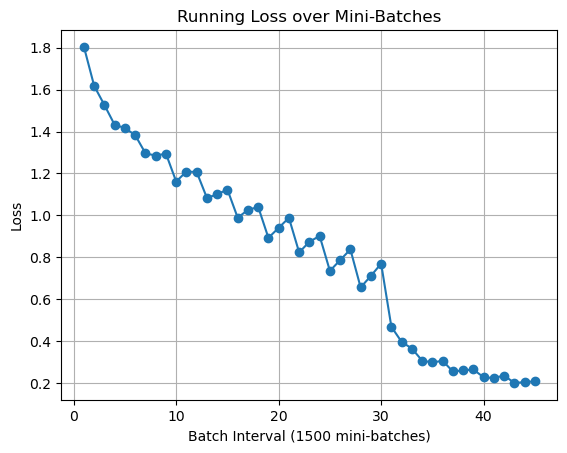

In [40]:
import matplotlib.pyplot as plt

# Define the function for plotting running loss
def plot_running_loss(running_loss_values):
    plt.figure()
    plt.plot(range(1, len(running_loss_values) + 1), running_loss_values, marker='o')
    plt.title("Running Loss over Mini-Batches")
    plt.xlabel("Batch Interval (1500 mini-batches)")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# Call the function to plot running loss over mini-batches
plot_running_loss(running_loss_values)


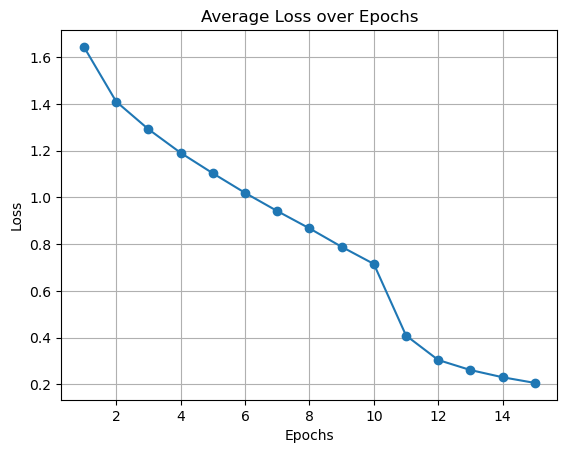

In [41]:
import matplotlib.pyplot as plt

# Define the function for plotting average loss
def plot_average_loss(average_loss_values):
    plt.figure()
    # Use the actual number of epochs for which you have data
    plt.plot(range(1, len(average_loss_values) + 1), average_loss_values, marker='o')
    plt.title("Average Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# Call the function to plot average loss over epochs
plot_average_loss(average_loss_values)


## 7. accuracy plot

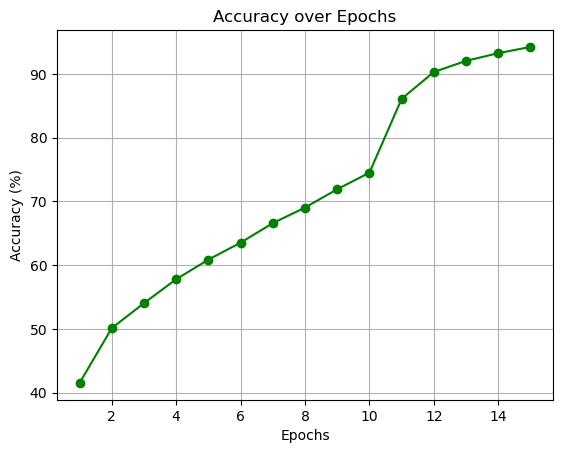

In [42]:
import matplotlib.pyplot as plt

# Define the function to plot accuracy
def plot_accuracy(accuracy_values):
    plt.figure()
    # Use the actual number of data points in accuracy_values
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', color='green')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.show()

# Call the function to plot accuracy
plot_accuracy(accuracy_values)

## 8. Model evaluation: Overall accuracy on the test set 

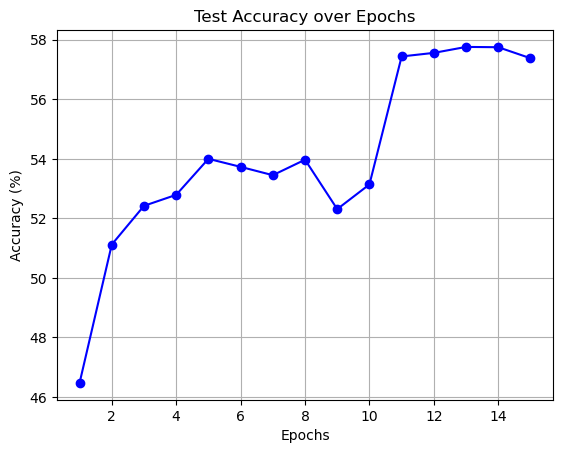

In [43]:
import torch
import os
import matplotlib.pyplot as plt

def evaluate_and_plot_accuracies(model_class, testloader, device, weights_directory, num_epochs):
    test_accuracies = []  # List to store test accuracies for each epoch

    # Iterate through all saved model files and evaluate
    for epoch in range(1, num_epochs + 1):
        model = model_class().to(device)  # Initialize a new instance of the model
        model_path = os.path.join(weights_directory, f'weights_epoch_{epoch}.pth')
        
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path))  # Load model weights
            model.eval()  # Set model to evaluation mode

            test_correct = 0
            test_total = 0
            with torch.no_grad():  # Disable gradient computation for evaluation
                for test_images, test_labels in testloader:
                    test_images, test_labels = test_images.to(device), test_labels.to(device)
                    test_outputs = model(test_images)
                    _, test_predicted = torch.max(test_outputs.data, 1)
                    test_total += test_labels.size(0)
                    test_correct += (test_predicted == test_labels).sum().item()

            test_accuracy = (test_correct / test_total) * 100
            test_accuracies.append(test_accuracy)
        else:
            print(f"Model file for epoch {epoch} not found, skipping...")

    # Plot the test accuracies
    plt.figure()
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', color='blue')
    plt.title("Test Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.show()

# Example usage
evaluate_and_plot_accuracies(FeedForwardNetwork, testloader, device, 'weights', num_epochs)


## 9. Precision and recall 

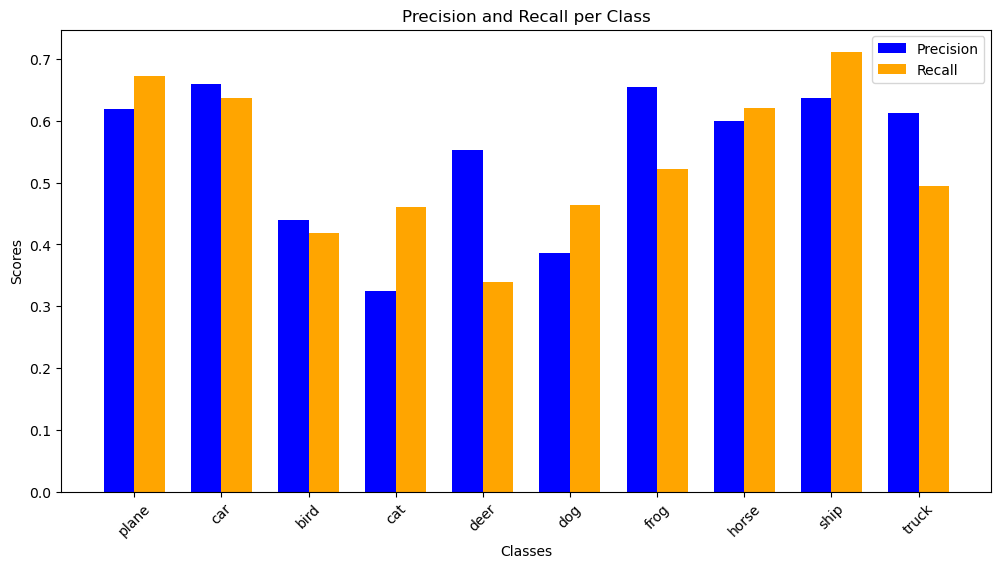

In [81]:
import torch
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Lists to store precision and recall values for each class
precision_values = []
recall_values = []

# Evaluate the model on the test set and gather predictions and labels
model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate precision and recall for each class
precision_values = precision_score(all_labels, all_preds, average=None)  # Precision per class
recall_values = recall_score(all_labels, all_preds, average=None)  # Recall per class

# Visualize precision and recall side by side
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
x = np.arange(len(classes))  # The label locations

bar_width = 0.35  # Width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, precision_values, bar_width, label='Precision', color='blue')
plt.bar(x + bar_width/2, recall_values, bar_width, label='Recall', color='orange')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision and Recall per Class')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.show()


## 10. weight distributions plot


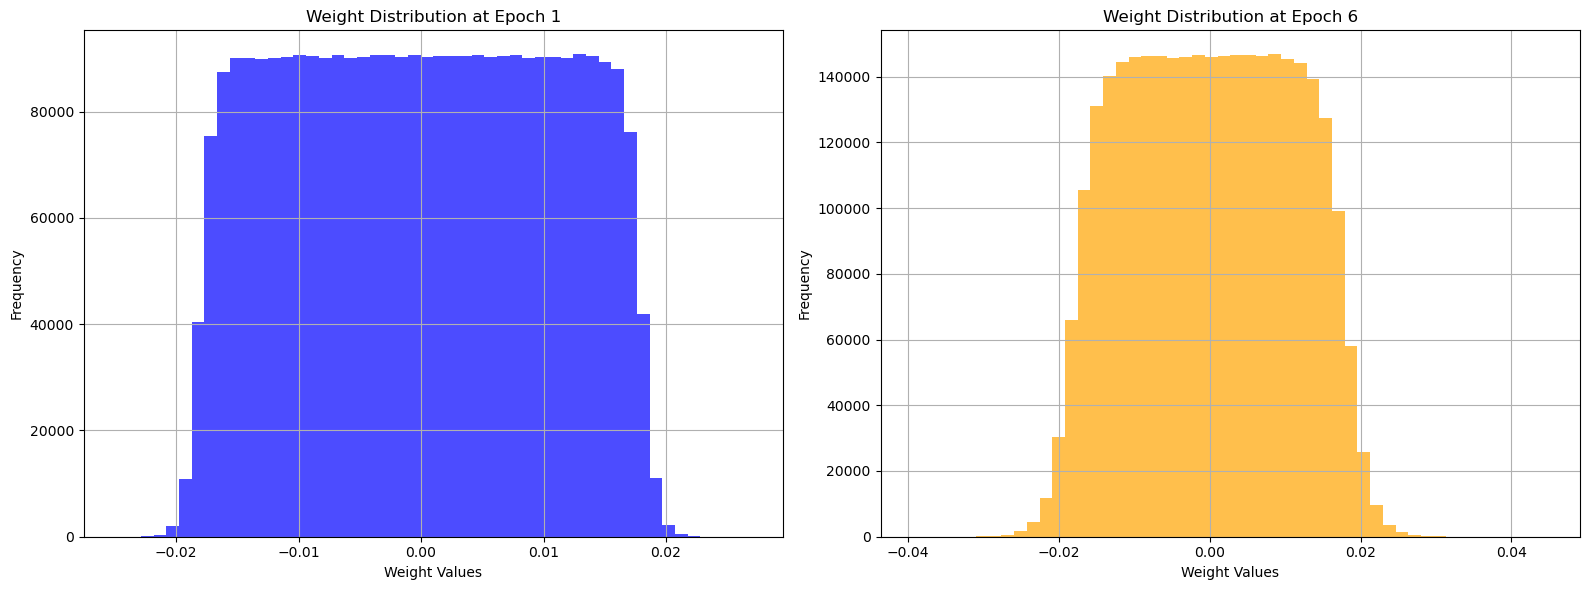

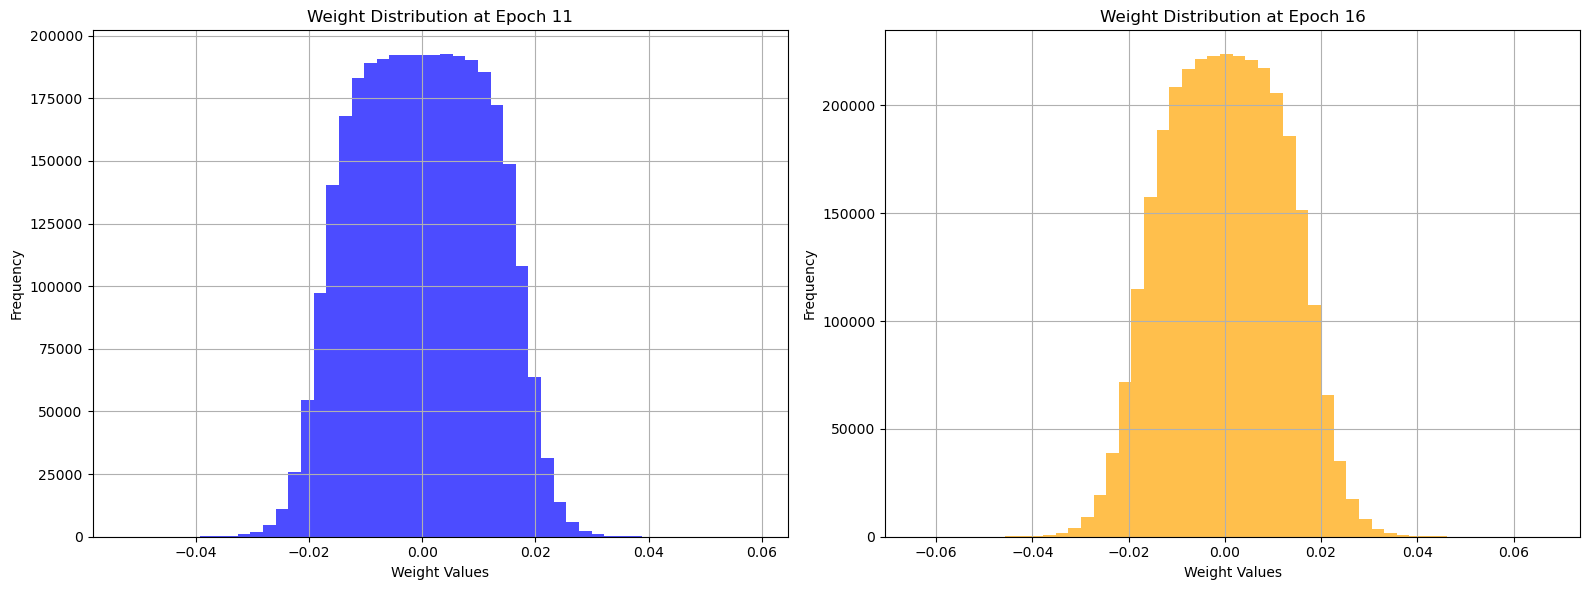

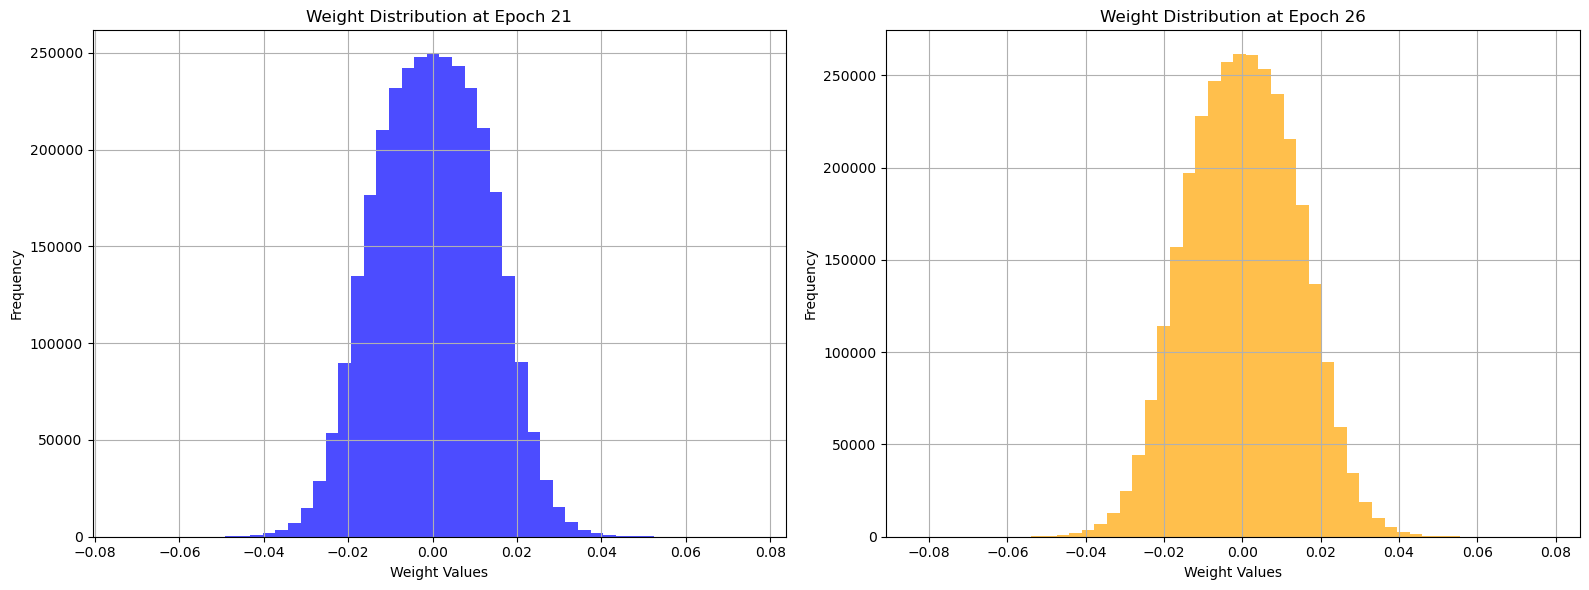

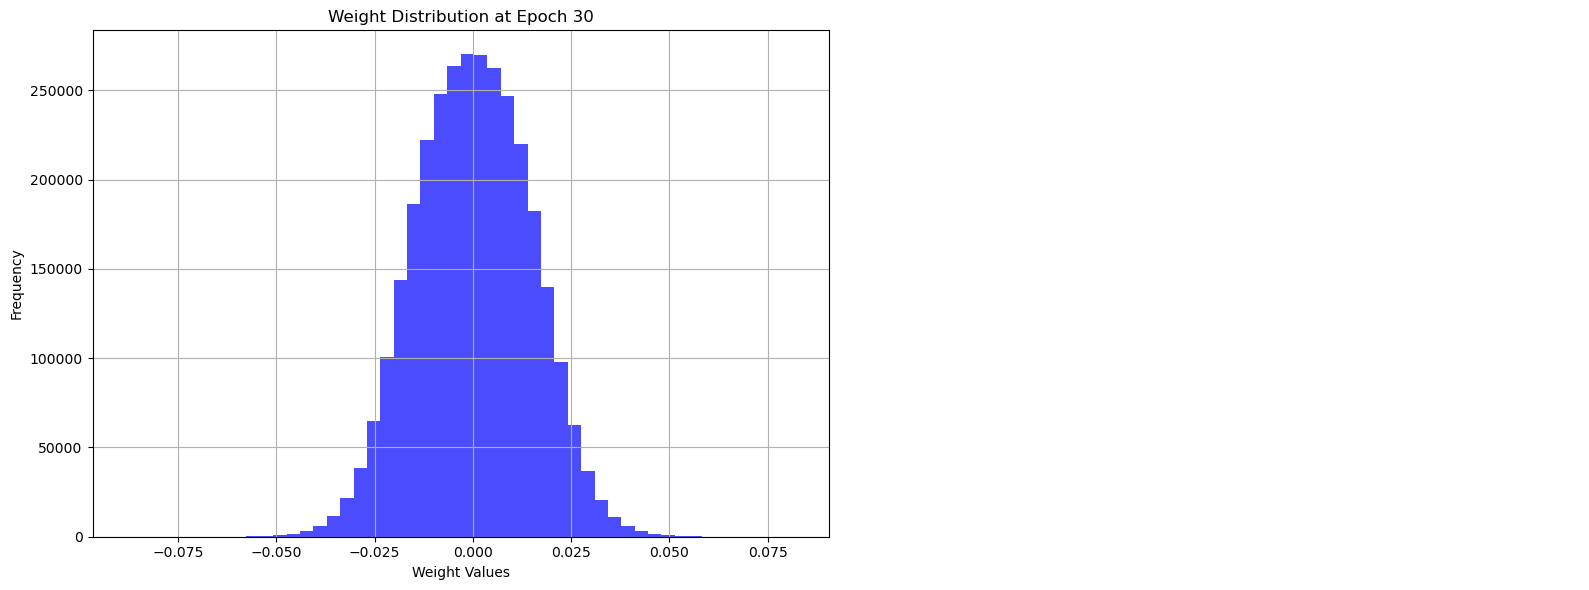

In [84]:
import torch
import matplotlib.pyplot as plt

def plot_weight_distributions_across_epochs(total_epochs, layer_name='fc1.weight', interval=5):
    """
    Plots the distribution of weights from specified epochs in pairs of side-by-side diagrams.

    Parameters:
    - total_epochs: The total number of epochs.
    - layer_name: The name of the layer whose weights you want to visualize.
    - interval: The interval at which to plot weight distributions (e.g., every 5 epochs).
    """
    # Generate a list of epochs to plot, including the last epoch if not already included
    epoch_list = list(range(1, total_epochs + 1, interval))
    if total_epochs not in epoch_list:
        epoch_list.append(total_epochs)
    
    # Plot in pairs
    for i in range(0, len(epoch_list), 2):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with two subplots side by side
        
        # Plot the first diagram
        epoch = epoch_list[i]
        file_path = f'weights/weights_epoch_{epoch}.pth'
        weights = torch.load(file_path)
        layer_weights = weights[layer_name].flatten().numpy()
        axes[0].hist(layer_weights, bins=50, alpha=0.7, color='blue')
        axes[0].set_title(f"Weight Distribution at Epoch {epoch}")
        axes[0].set_xlabel("Weight Values")
        axes[0].set_ylabel("Frequency")
        axes[0].grid(True)
        
        # Plot the second diagram if there is another epoch in the list
        if i + 1 < len(epoch_list):
            epoch = epoch_list[i + 1]
            file_path = f'weights/weights_epoch_{epoch}.pth'
            weights = torch.load(file_path)
            layer_weights = weights[layer_name].flatten().numpy()
            axes[1].hist(layer_weights, bins=50, alpha=0.7, color='orange')
            axes[1].set_title(f"Weight Distribution at Epoch {epoch}")
            axes[1].set_xlabel("Weight Values")
            axes[1].set_ylabel("Frequency")
            axes[1].grid(True)
        else:
            axes[1].axis('off')  # Turn off the second plot if there is no second epoch to plot

        plt.tight_layout()
        plt.show()

# Call the function to plot weight distributions across specified epochs
plot_weight_distributions_across_epochs(num_epochs, layer_name='fc1.weight', interval=5)


## 10. Confusion matrix

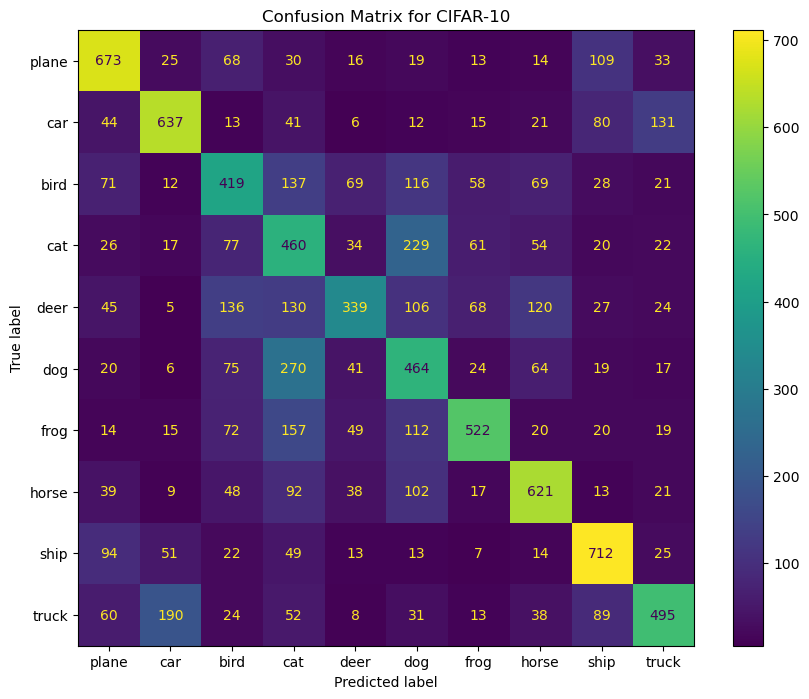

In [85]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the confusion matrix plotting function
def plot_confusion_matrix(model, testloader, classes, device):
    # Set the model to evaluation mode
    model.eval()
    
    all_preds = []
    all_labels = []

    # Disable gradient calculation for inference
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Display the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, cmap='viridis')
    plt.title("Confusion Matrix for CIFAR-10")
    plt.show()

# Define the class labels for CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Call the function to plot the confusion matrix
plot_confusion_matrix(model, testloader, classes, device)

